In [1]:
# imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from moduleLoading import LoadingMethods
from modulePreProcessing import ScalingMethods, FeatureMethods, boxplot_features
from moduleModelTraining import TrainingMethods
from moduleMetrics import MetricsMethods
from sklearn.preprocessing import OneHotEncoder, StandardScaler, KBinsDiscretizer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from collections import Counter
from joblib import dump
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from sklearn.ensemble import RandomForestClassifier

In [2]:
# open Jupyter QtConsole
%qtconsole

In [3]:
# class instances
load = LoadingMethods()
scale = ScalingMethods()
fm = FeatureMethods()
train = TrainingMethods()
evaluate = MetricsMethods()

In [4]:
# final features
ff = []

In [5]:
# connect to db and fetch data
df = load.connect_and_fetch("127.0.0.1", "mci_db", "root", "toor", "SELECT * FROM v7")
df.head()

,gsId,gsStartTime,age,sex,education,laptop_usage,smartphone_usage,smoking,family_med_history,exercising,...,moca_pre_severity_binned,moca_pre_binary_binned,mmse_post_init,mmse_post_severity_binned,mmse_post_binary_binned,moca_post_init,moca_post_severity_binned,moca_post_binary_binned,mmse_post_pre_diff,moca_post_pre_diff
0,18245,1560929400,70,1,4,0,0,0,1,0,...,2,1,21,2,1,23,2,1,3,4
1,76067,1555499640,61,1,4,1,3,0,1,1,...,2,1,29,3,2,26,3,2,0,2
2,79781,1557928260,83,1,5,1,1,0,0,1,...,2,1,25,3,2,22,2,1,-4,-3
3,180144,1557315840,71,1,2,0,4,0,0,1,...,3,2,29,3,2,25,2,1,-1,-2
4,209758,1560933840,75,1,2,0,0,0,1,0,...,2,1,18,2,1,19,2,1,-3,-2


In [6]:
# define target class (14 available, 6 moca, 6 mmse, 2 diffs)
target_class = "moca_pre_binary_binned"
df = load.separate_target_class(df, target_class)
df.head()

,gsId,gsStartTime,age,sex,education,laptop_usage,smartphone_usage,smoking,family_med_history,exercising,...,marital_status,depression,hypertension,total_gr_in_gs_fixed_width_binned,total_gr_in_gs,total_success_rounds_in_session,total_win_gr_points_in_gs,avg_gr_time_in_gs,avg_gr_time_win_gr_in_gs,target_class
gsId,,,,,,,,,,,,,,,,,,,,,
18245,18245,1560929400,70,1,4,0,0,0,1,0,...,1,0,0,0,7,1.0,33.0,14.7143,17.0,1
76067,76067,1555499640,61,1,4,1,3,0,1,1,...,3,0,1,3,37,4.0,67.0,41.7568,53.0,1
79781,79781,1557928260,83,1,5,1,1,0,0,1,...,1,0,0,1,11,4.0,17.0,38.1818,51.5,1
180144,180144,1557315840,71,1,2,0,4,0,0,1,...,1,0,1,3,37,1.0,39.0,34.4324,4.0,2
209758,209758,1560933840,75,1,2,0,0,0,1,0,...,3,0,1,2,24,1.0,26.0,29.9583,11.0,1


In [7]:
# discretize !!! also totals and avgs? check!
discretizer = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
dfPartToDiscretize = df['age']
df['age'] = discretizer.fit_transform(df[['age']])
df.head()

,gsId,gsStartTime,age,sex,education,laptop_usage,smartphone_usage,smoking,family_med_history,exercising,...,marital_status,depression,hypertension,total_gr_in_gs_fixed_width_binned,total_gr_in_gs,total_success_rounds_in_session,total_win_gr_points_in_gs,avg_gr_time_in_gs,avg_gr_time_win_gr_in_gs,target_class
gsId,,,,,,,,,,,,,,,,,,,,,
18245,18245,1560929400,0.0,1,4,0,0,0,1,0,...,1,0,0,0,7,1.0,33.0,14.7143,17.0,1
76067,76067,1555499640,0.0,1,4,1,3,0,1,1,...,3,0,1,3,37,4.0,67.0,41.7568,53.0,1
79781,79781,1557928260,3.0,1,5,1,1,0,0,1,...,1,0,0,1,11,4.0,17.0,38.1818,51.5,1
180144,180144,1557315840,1.0,1,2,0,4,0,0,1,...,1,0,1,3,37,1.0,39.0,34.4324,4.0,2
209758,209758,1560933840,2.0,1,2,0,0,0,1,0,...,3,0,1,2,24,1.0,26.0,29.9583,11.0,1


In [8]:
# encoding of categorical to numerical. 
# no need for that particular encoding,
# since we fetch their ids from the view.

total_win_gr_points_in_gs 7534.3
avg_gr_time_win_gr_in_gs 372.0
avg_gr_time_in_gs 255.0
total_gr_in_gs 126.1
total_success_rounds_in_session 17.2
smartphone_usage 2.3
total_gr_in_gs_fixed_width_binned 1.4
age 1.3
education 1.1
marital_status 1.0
laptop_usage 0.9
family_med_history 0.3
exercising 0.2
hypertension 0.2
marital_status_1 0.2
marital_status_3 0.2
sex 0.1
depression 0.1
smoking 0.1
marital_status_5 0.0
marital_status_4 0.0
marital_status_2 0.0
marital_status_0 0.0
Threshold value:  0.16
Features ruled out: 
 ['sex', 'smoking', 'marital_status_0', 'marital_status_2', 'marital_status_4', 'marital_status_5', 'depression']


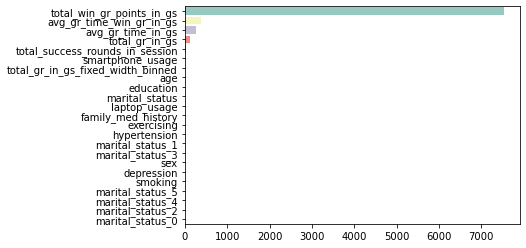

In [9]:
# remove low variance features
df = fm.remove_low_variance_features(df, (.8 * (1 - .8)))

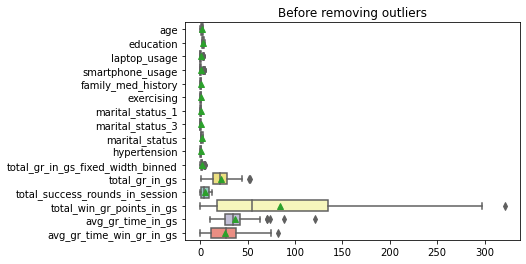

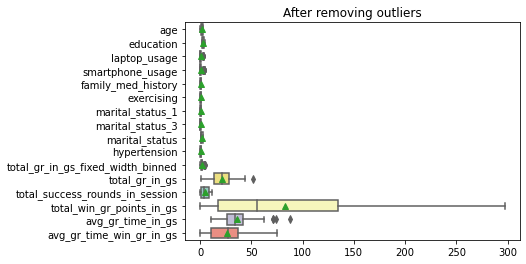

In [10]:
# handle outliers
df = scale.handle_outliers(df)

In [11]:
# # print(df.describe())
# sns.pairplot(df[['smartphone_usage', 'age', 'target_class']])
# plt.show()


# p = sns.pairplot(df[['total_gr_in_gs', 'avg_gr_time_in_gs', 'target_class']], hue='target_class', markers=["x", "o"])
# new_title = 'My title'
# new_labels = ['MCI', 'NC']
# p._legend.set_title(new_title)
# for t, l in zip(p._legend.texts, new_labels): t.set_text(l)
# plt.show()

# p = sns.pairplot(df[['age', 'smartphone_usage', 'target_class']], hue='target_class', markers=["x", "o"])
# new_title = 'My title'
# new_labels = ['MCI', 'NC']
# p._legend.set_title(new_title)
# for t, l in zip(p._legend.texts, new_labels): t.set_text(l)
# plt.show()

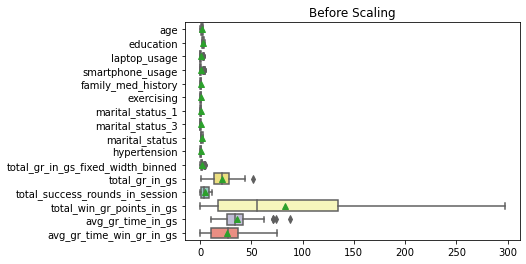

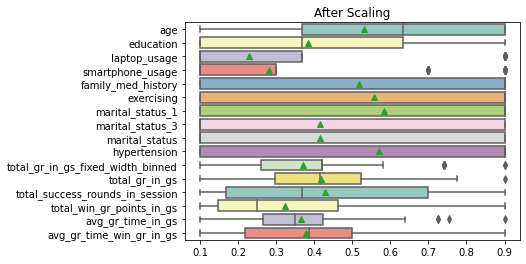

In [12]:
# scaling
columnsToIgnore = ['gsId', 'gsStartTime', 'target_class']
df = scale.use_min_max(df, columnsToIgnore)

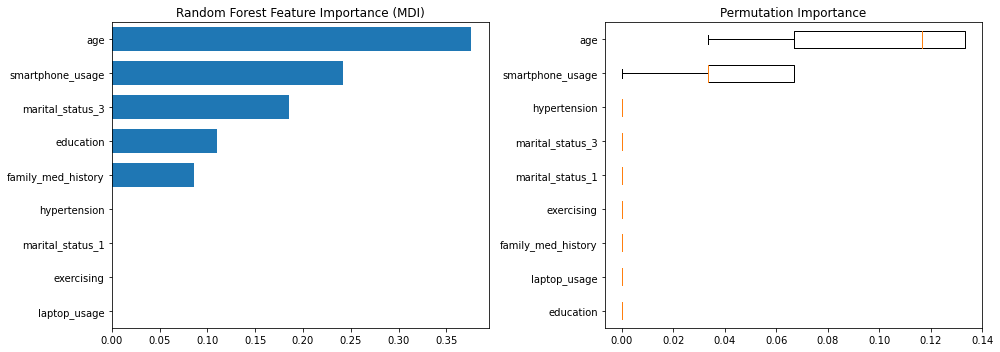

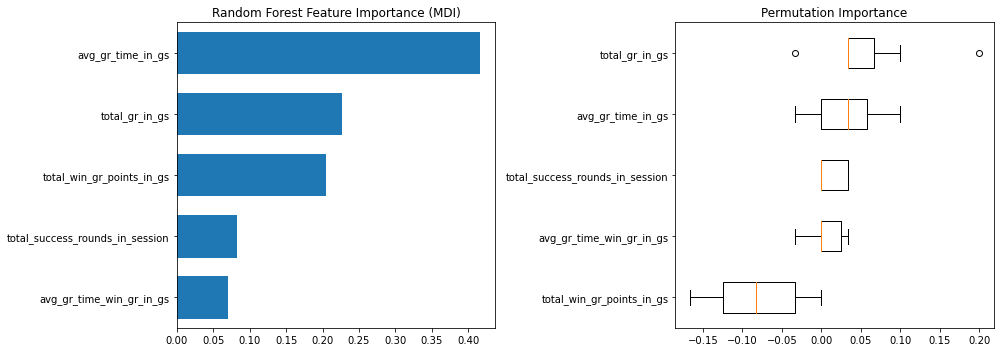

In [13]:
# feature importance inspection using a classifier
# MDI feature importance and feature values permutation importance

# user related independent variables
features_to_inspect = ['age', 'education','laptop_usage', 'smartphone_usage', 'family_med_history', 'exercising', 
                       'marital_status_1', 'marital_status_3', 'hypertension']
fm.inspection_using_classifier(df, features_to_inspect)

# session data related independent variables
features_to_inspect = ['total_gr_in_gs', 'total_success_rounds_in_session', 'total_win_gr_points_in_gs', 'avg_gr_time_in_gs', 
                       'avg_gr_time_win_gr_in_gs']

fm.inspection_using_classifier(df, features_to_inspect)

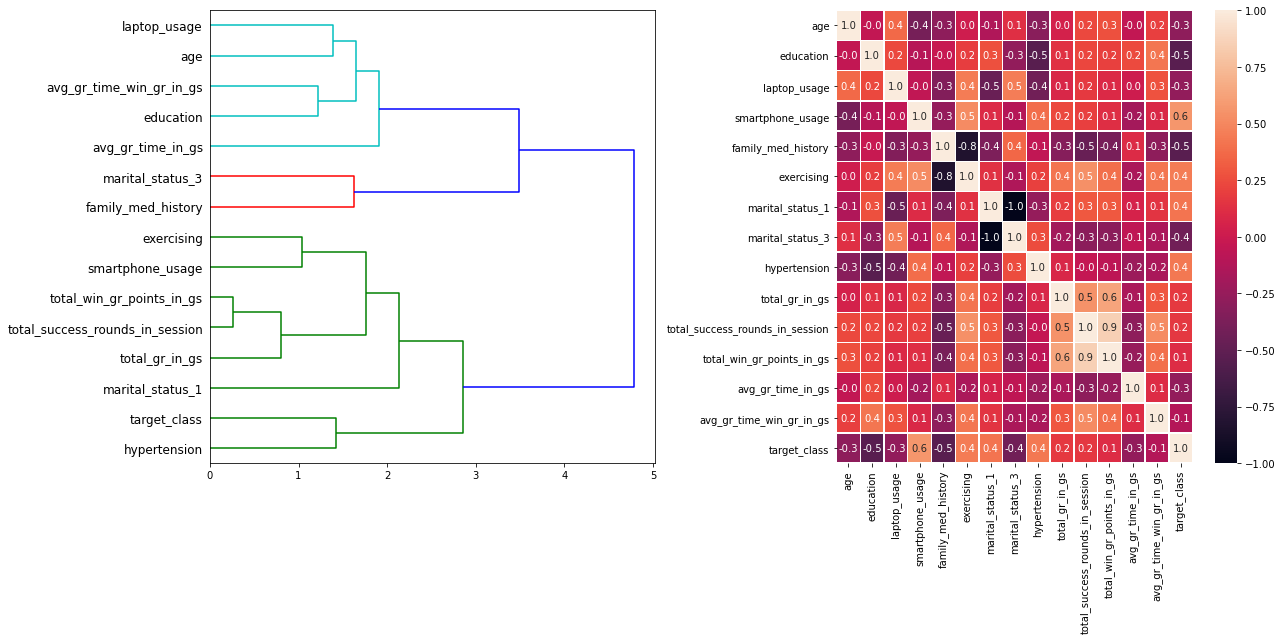

In [43]:
# feature correlation inspection

fs = ['age', 'education','laptop_usage', 'smartphone_usage', 'family_med_history', 'exercising', 'marital_status_1',
      'marital_status_3', 'hypertension', 'total_gr_in_gs', 'total_success_rounds_in_session', 'total_win_gr_points_in_gs', 
      'avg_gr_time_in_gs', 'avg_gr_time_win_gr_in_gs', 'target_class']

fm.feature_correlation_inspection(df, fs)

<BarContainer object of 14 artists>

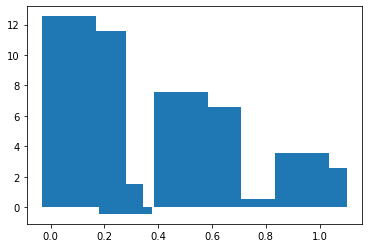

In [23]:
# Univariate Feature Selection

# example
# https://scikit-learn.org/stable/auto_examples/feature_selection/plot_feature_selection.html

# https://nbviewer.jupyter.org/github/justmarkham/scikit-learn-tips/blob/master/notebooks/23_linear_model_coefficients.ipynb
# https://scikit-learn.org/stable/auto_examples/feature_selection/plot_feature_selection.html#sphx-glr-auto-examples-feature-selection-plot-feature-selection-py

X = df[['age', 'education','laptop_usage', 'smartphone_usage',
        'family_med_history', 'exercising', 'marital_status_1', 
        'marital_status_3', 'hypertension', 'total_gr_in_gs', 
        'total_success_rounds_in_session', 'total_win_gr_points_in_gs', 
        'avg_gr_time_in_gs', 'avg_gr_time_win_gr_in_gs']]

targetClassIndex = df.columns.get_loc('target_class')
y = df.iloc[:, targetClassIndex]

# Split dataset to select feature and evaluate the classifier
X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, random_state=0
)

plt.figure(1)
plt.clf()

X_indices = np.arange(X.shape[-1])

# #############################################################################
# Univariate feature selection with F-test for feature scoring
# We use the default selection function to select the four
# most significant features
selector = SelectKBest(f_classif, k=4)
selector.fit(X_train, y_train)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()
plt.bar(scores, X_indices - .45, width=.2,
        label=r'Univariate score ($-Log(p_{value})$)')

In [16]:
# feature selection for user demographics, medical profile, technology familiarity related features

# independent variables
X = df[['age', 'education','laptop_usage', 'smartphone_usage', 
         'family_med_history', 'exercising', 'marital_status_1', 
         'marital_status_3', 'hypertension']]

# target class
targetClassIndex = df.columns.get_loc('target_class')
y = df.iloc[:, targetClassIndex]

# feature selection
selector = SelectKBest(chi2, k=2)
Xresults = selector.fit_transform(X.values, y.values)
# selector = check if this model returns coeffs

# print(Xresults.shape)
# print(type(Xresults))
#get selected as: array([3, 4], dtype=int64)
selectedFeaturesIndices = selector.get_support(indices=True)
# print('selectedFeaturesIndices ', selectedFeaturesIndices)

#get selected as: Index(['age', 'education'], dtype='object')
selectedFeaturesIndicesNames = X.columns[selectedFeaturesIndices.tolist()]
# print('selectedFeaturesIndicesNames ', selectedFeaturesIndicesNames)

#get selected as list: ['age', 'education']
selectedFeatures = X.columns[selectedFeaturesIndices.tolist()].values.tolist()
print(selectedFeatures)
ff += selectedFeatures

['smartphone_usage', 'family_med_history']


In [17]:
# feature selection for MCI Rehab recorded game performance related features

# independent variables
X = df[['total_gr_in_gs', 'total_success_rounds_in_session', 
        'total_win_gr_points_in_gs', 'avg_gr_time_in_gs', 
        'avg_gr_time_win_gr_in_gs']]

# target class
targetClassIndex = df.columns.get_loc('target_class')
y = df.iloc[:, targetClassIndex]

# feature selection
selector = SelectKBest(chi2, k=2)
Xresults = selector.fit_transform(X.values, y.values)
# print(Xresults.shape)
# print(type(Xresults))
#get selected as: array([3, 4], dtype=int64)
selectedFeaturesIndices = selector.get_support(indices=True)
# print('selectedFeaturesIndices ', selectedFeaturesIndices)

#get selected as: Index(['age', 'education'], dtype='object')
selectedFeaturesIndicesNames = X.columns[selectedFeaturesIndices.tolist()]
# print('selectedFeaturesIndicesNames ', selectedFeaturesIndicesNames)

#get selected as list: ['age', 'education']
selectedFeatures = X.columns[selectedFeaturesIndices.tolist()].values.tolist()
print(selectedFeatures)
ff += selectedFeatures

['total_success_rounds_in_session', 'avg_gr_time_in_gs']


In [19]:
# train models

# Either shuffle=True, random_state=7 Or stratify=y
X_train, X_test, y_train, y_test = train_test_split(df[ff], y, test_size=0.3, shuffle=False)

clfs = {
    'lr': LogisticRegression(random_state=7),
    'dt' : DecisionTreeClassifier(max_depth=4),
    'rf' : RandomForestClassifier(max_depth=4, random_state=7)
}
custom_ensemble = VotingClassifier([('clf1', clfs.get('lr')), 
                                    ('clf2', clfs.get('dt')), 
                                    ('clf3', clfs.get('rf'))], voting='soft')
clfs['ce'] = custom_ensemble

trained_models = train.train_models(clfs, X_train, y_train)

Metrics for  Logistic Regression
accuracy  Score: 88.889% Std.: 3.928%
precision  Score: 88.889% Std.: 3.928%
recall  Score: 100.000% Std.: 0.000%
f1  Score: 94.071% Std.: 2.236%
############## 

Metrics for  Decision Tree
accuracy  Score: 86.111% Std.: 14.164%
precision  Score: 90.556% Std.: 8.203%
recall  Score: 93.333% Std.: 9.428%
f1  Score: 91.884% Std.: 8.589%
############## 

Metrics for  Random Forest
accuracy  Score: 91.667% Std.: 6.804%
precision  Score: 91.667% Std.: 6.804%
recall  Score: 100.000% Std.: 0.000%
f1  Score: 95.520% Std.: 3.713%
############## 

Metrics for  Custom Ensemble
accuracy  Score: 91.667% Std.: 6.804%
precision  Score: 91.667% Std.: 6.804%
recall  Score: 100.000% Std.: 0.000%
f1  Score: 95.520% Std.: 3.713%
############## 



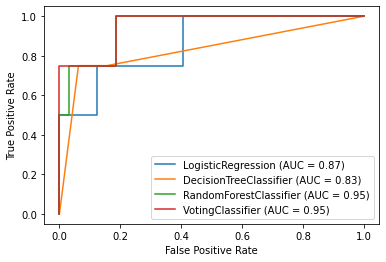

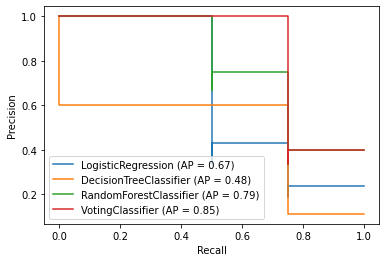

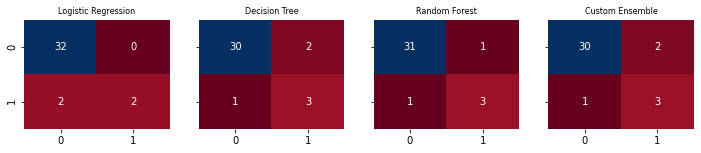

In [20]:
# evaluate models
evaluate.generate_metrics(trained_models, X_test, y_test, ['accuracy', 'precision', 'recall', 'f1'], show_raw_data=False)